# Business Impact Scenarios: Subscription Churn & Value Segmentation

**Executive Summary**

In subscription-based businesses, offering blanket discounts to retain users is often a costly mistake. Many users would have renewed anyway, and others may not generate enough future revenue to justify the discount. 

This notebook demonstrates a **Smart Retention Strategy** that combines:
1. **Predictive Modeling (XGBoost):** To identify users with a high probability of churning in the next 30 days.
2. **Customer Segmentation (K-Means):** To identify high-value users based on their Recency, Frequency, and Monetary (RFM) metrics, as well as their engagement.

By targeting only the "High-Value Whales" and "Power Users" who are actually at risk of churning, we can drastically reduce campaign costs and improve Net ROI.

In [55]:
from __future__ import annotations

import sys
from pathlib import Path

# Resolve project root so imports work whether you run from repo root or notebooks/
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists() and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

FIG_DIR = PROJECT_ROOT / "figures"
FIG_DIR.mkdir(exist_ok=True)

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from src.data_loader import load_all_data
from src.features import engineer_features
from src.models import get_splits, make_pipeline, train_models
from src.segmentation import segment_users_kmeans

# --- Premium Visualization Setup ---
sns.set_theme(style="white", context="talk")
plt.rcParams.update({
    "font.family": "sans-serif",
    "axes.edgecolor": "#444444",
    "axes.labelcolor": "#444444",
    "axes.titlesize": 20,
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "xtick.color": "#444444",
    "ytick.color": "#444444",
    "figure.titlesize": 22,
    "figure.dpi": 150,
})

# Professional color palette (Midnight Blue for status quo, Teal for smart strategy)
PALETTE = {"Blanket Strategy": "#4A4E69", "Smart (ML) Strategy": "#2A9D8F"}
sns.set_palette(list(PALETTE.values()))

## 1. Getting Live Predictions

First, we load the data, engineer features, and train our XGBoost model. We also segment the users using K-Means clustering to identify our high-value personas.

In [57]:
# Load and engineer data
m, t, u = load_all_data()
max_date = t["transaction_date"].max()
CUTOFF = max_date - pd.Timedelta(days=30)
X, y = engineer_features(m, t, u, CUTOFF)

# Train Model
X_train, X_test, y_train, y_test = get_splits(X, y)
preprocessor = make_pipeline(X_train)
_, xgb_model = train_models(X_train, y_train, preprocessor)

# Segment Users
segmented_users = segment_users_kmeans(X)

# Generate Predictions for the entire cohort
churn_probs = xgb_model.predict_proba(X.drop(columns=["msno"]))[:, 1]
segmented_users["churn_probability"] = churn_probs
segmented_users["is_churn_actual"] = y["is_churn"]

training LR...
training XGBoost...
running kmeans...


In [58]:
from src.models import evaluate_model

# Evaluate the model to see its raw performance (ROC-AUC, PR-AUC)
metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

--- XGBoost Evaluation ---
ROC-AUC: 0.9471
PR-AUC: 0.1432
Brier-Score: 0.0109


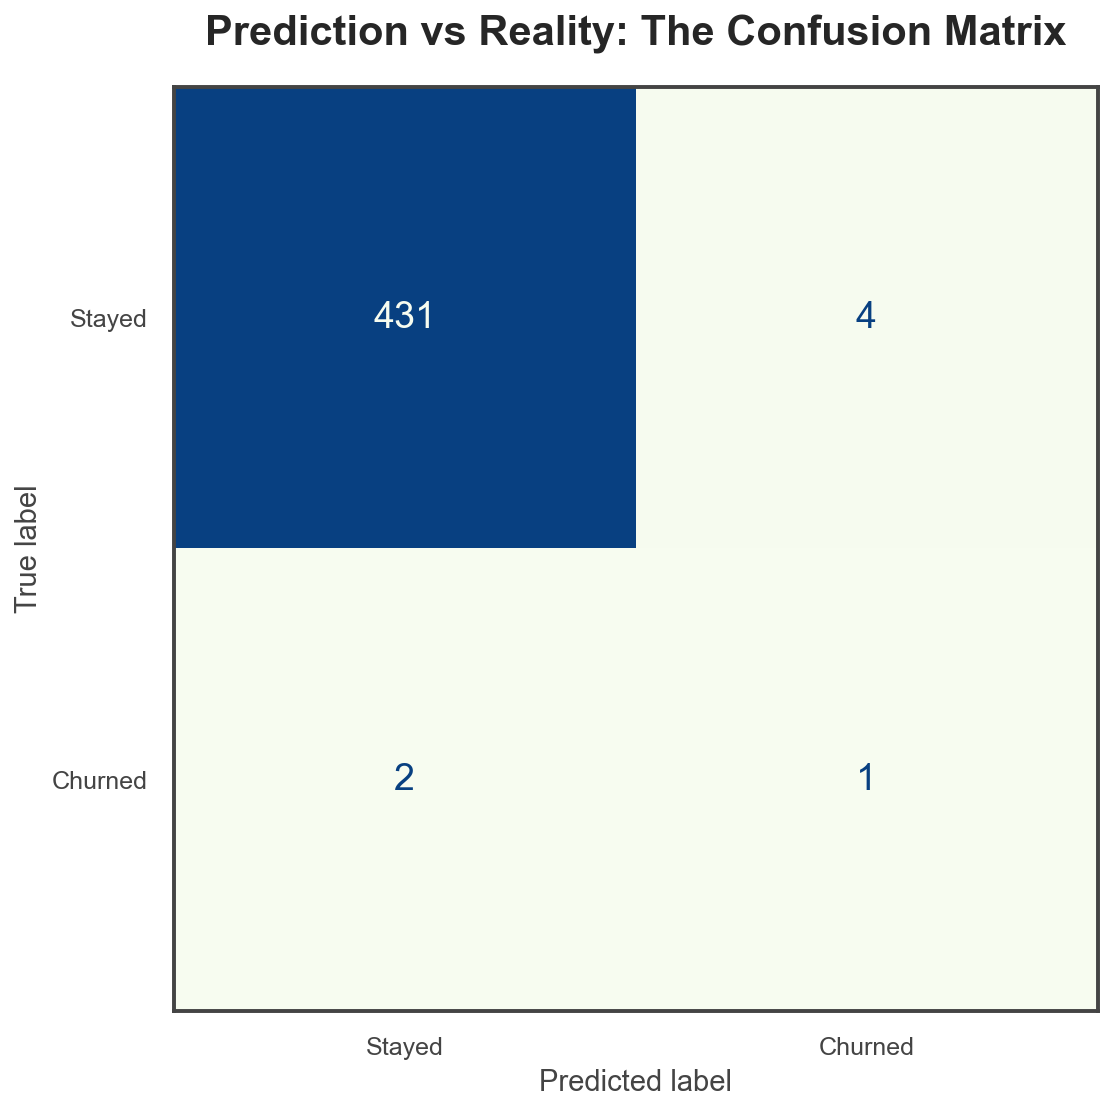

Saved confusion matrix to: C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\figures\confusion_matrix.png


In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute Confusion Matrix on TEST SET only (for representative evaluation)
test_probs = xgb_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, test_probs > 0.5)

# --- Visual Polish for Confusion Matrix ---
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Churned"])
disp.plot(cmap="GnBu", ax=ax, values_format="d", colorbar=False)
ax.grid(False) # Matrix shouldn't have gridlines
ax.set_title("Prediction vs Reality: The Confusion Matrix", pad=20)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.tick_params(axis="both", labelsize=12)

# Save confusion matrix plot
out_path = FIG_DIR / "confusion_matrix.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved confusion matrix to: {out_path}")

## 2. What Actually Drives Churn?

Before we look at the business impact, let's use **SHAP (SHapley Additive exPlanations)** to understand what features are driving churn risk for these users. This interpretability is crucial for business stakeholders to trust the model.

C:\Users\Calla\AppData\Local\Temp\ipykernel_33368\3604013729.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, show=False)


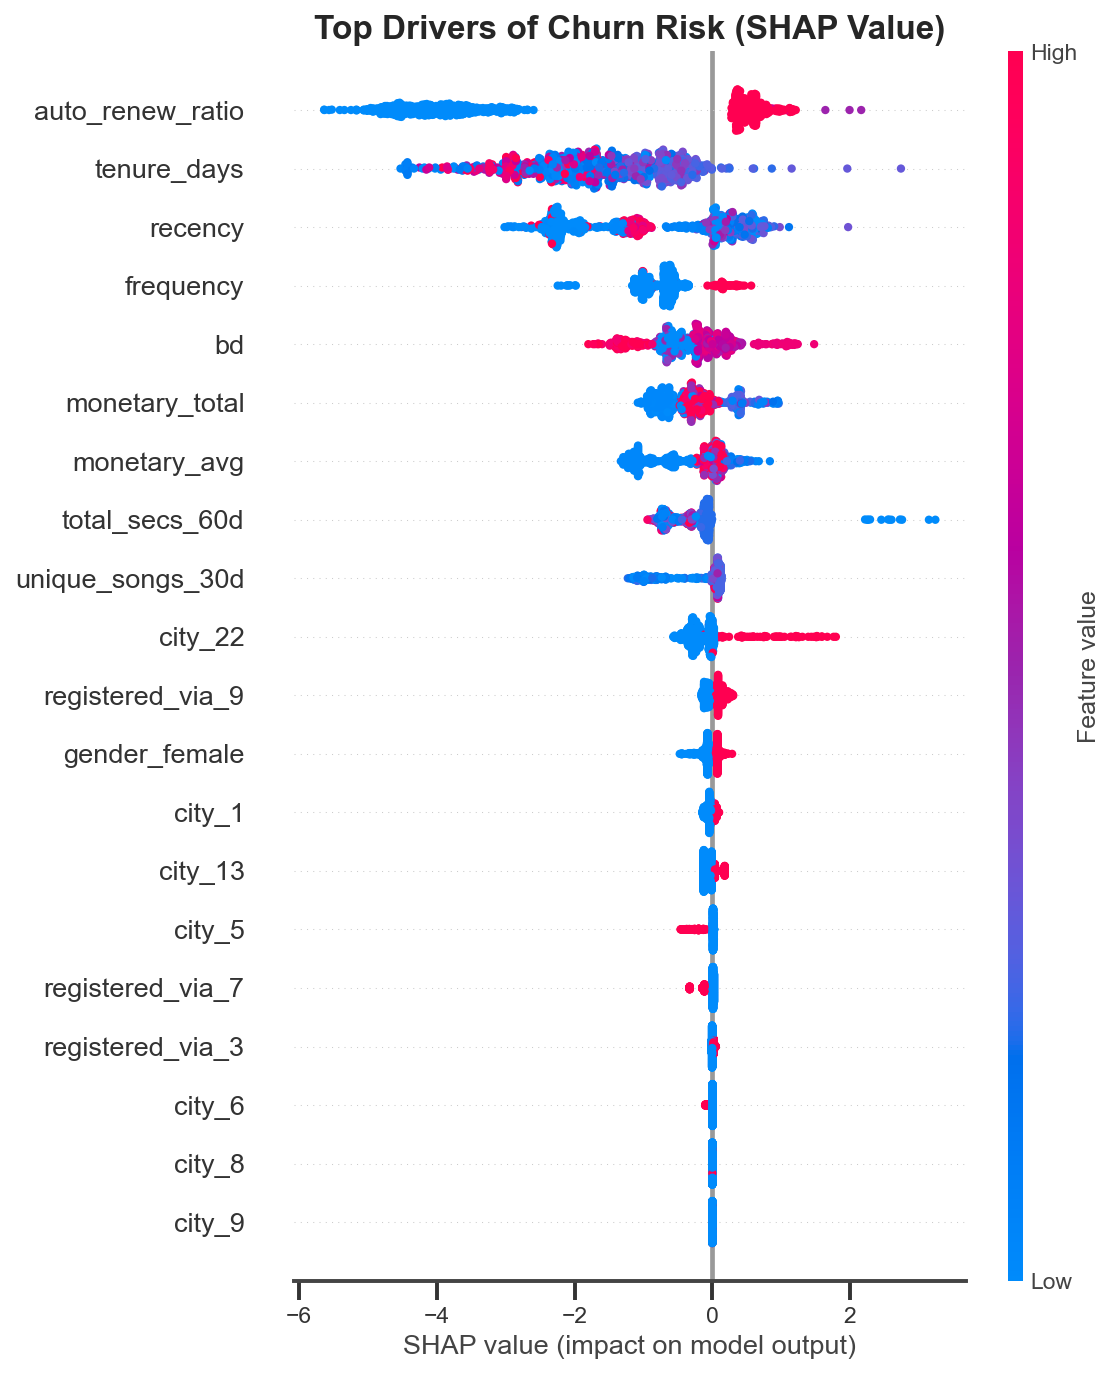

Saved SHAP summary to: C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\figures\shap_summary.png


In [60]:
# Extract the trained XGBoost estimator and transformed feature names
xgb_estimator = xgb_model.named_steps["classifier"]

# Apply preprocessor to get the feature matrix
X_train_transformed = preprocessor.fit_transform(X_train)

# Get feature names
num_features = preprocessor.transformers_[0][2]
cat_features = (
    preprocessor.transformers_[1][1]
    .named_steps["onehot"]
    .get_feature_names_out(preprocessor.transformers_[1][2])
 )
feature_names = list(num_features) + list(cat_features)

# Calculate SHAP values
# (Using a sample for computational speed in the notebook)
X_sample = pd.DataFrame(X_train_transformed[:1000], columns=feature_names)
explainer = shap.TreeExplainer(xgb_estimator)
shap_values = explainer.shap_values(X_sample)

# Plot Summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Top Drivers of Churn Risk (SHAP Value)", fontsize=16, fontweight="bold")
plt.tight_layout()

# Save a shareable artifact for README/website
out_path = FIG_DIR / "shap_summary.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved SHAP summary to: {out_path}")

**Interpretation:**
Features like `recency` (days since last transaction) and `is_auto_renew` strongly dictate churn. High recency (stale users) pushes churn risk higher, while having auto-renew enabled severely drops the risk. Engagement features (`total_secs_60d`) also show that declining usage correlates with higher churn.

## 3. Business Scenario: Targeted Retention ROI

If we just give everyone a 20% discount, we waste a ton of margin on users who would have renewed anyway, or users who are extremely low value.

Instead, we target only users in the **"High-Value Whales"** and **"Power Users"** personas, then select the **top churn-risk slice** within those personas using an adaptive threshold.

In [61]:
# Define Campaign Parameters
AVERAGE_LTV = 150.0  # Assumed LTV of a retained user in dollars
DISCOUNT_COST = 30.0  # Cost of the 20% discount campaign per targeted user
CAMPAIGN_SUCCESS_RATE = 0.25  # Assume 25% of targeted true-churners are saved

# 1. Blanket Strategy: Target Everyone
blanket_targeted = len(segmented_users)
blanket_cost = blanket_targeted * DISCOUNT_COST
blanket_saved = segmented_users["is_churn_actual"].sum() * CAMPAIGN_SUCCESS_RATE
blanket_revenue = blanket_saved * AVERAGE_LTV
blanket_roi = blanket_revenue - blanket_cost

# 2. Smart Strategy: Target High-Value personas + top-risk slice
TARGET_PERSONAS = ["High-Value Whales", "Power Users"]
TOP_RISK_SHARE = 0.20  # target top 20% highest-risk users within selected personas

persona_df = segmented_users[segmented_users["persona"].isin(TARGET_PERSONAS)].copy()

if len(persona_df) > 0:
    n_target = max(1, int(round(len(persona_df) * TOP_RISK_SHARE)))
    smart_df = persona_df.nlargest(n_target, "churn_probability")
else:
    # Fallback if personas are unavailable in a particular run
    n_target = max(1, int(round(len(segmented_users) * TOP_RISK_SHARE)))
    smart_df = segmented_users.nlargest(n_target, "churn_probability").copy()

smart_targeted = len(smart_df)
smart_threshold_used = smart_df["churn_probability"].min() if smart_targeted else 0.0
smart_cost = smart_targeted * DISCOUNT_COST
smart_saved = smart_df["is_churn_actual"].sum() * CAMPAIGN_SUCCESS_RATE
smart_revenue = smart_saved * AVERAGE_LTV
smart_roi = smart_revenue - smart_cost

# Results Table
roi_comparison = pd.DataFrame(
    {
        "Metric": [
            "Users Targeted",
            "Risk Threshold (Smart)",
            "Campaign Cost",
            "Users Saved",
            "Retained Revenue",
            "Net ROI",
        ],
        "Blanket Strategy": [
            blanket_targeted,
            "N/A",
            f"${blanket_cost:,.0f}",
            f"{blanket_saved:.2f}",
            f"${blanket_revenue:,.0f}",
            f"${blanket_roi:,.0f}",
        ],
        "Smart (ML) Strategy": [
            smart_targeted,
            f">= {smart_threshold_used:.3f}",
            f"${smart_cost:,.0f}",
            f"{smart_saved:.2f}",
            f"${smart_revenue:,.0f}",
            f"${smart_roi:,.0f}",
        ],
    }
)

roi_comparison

,Metric,Blanket Strategy,Smart (ML) Strategy
0,Users Targeted,2188,32
1,Risk Threshold (Smart),N/A,>= 0.005
2,Campaign Cost,"$65,640",$960
3,Users Saved,3.75,0.25
4,Retained Revenue,$562,$38
5,Net ROI,"$-65,078",$-922


## 4. Visualizing the ROI Comparison

Let's plot the difference in Campaign Cost and Net ROI between the two strategies to make the business case clear.

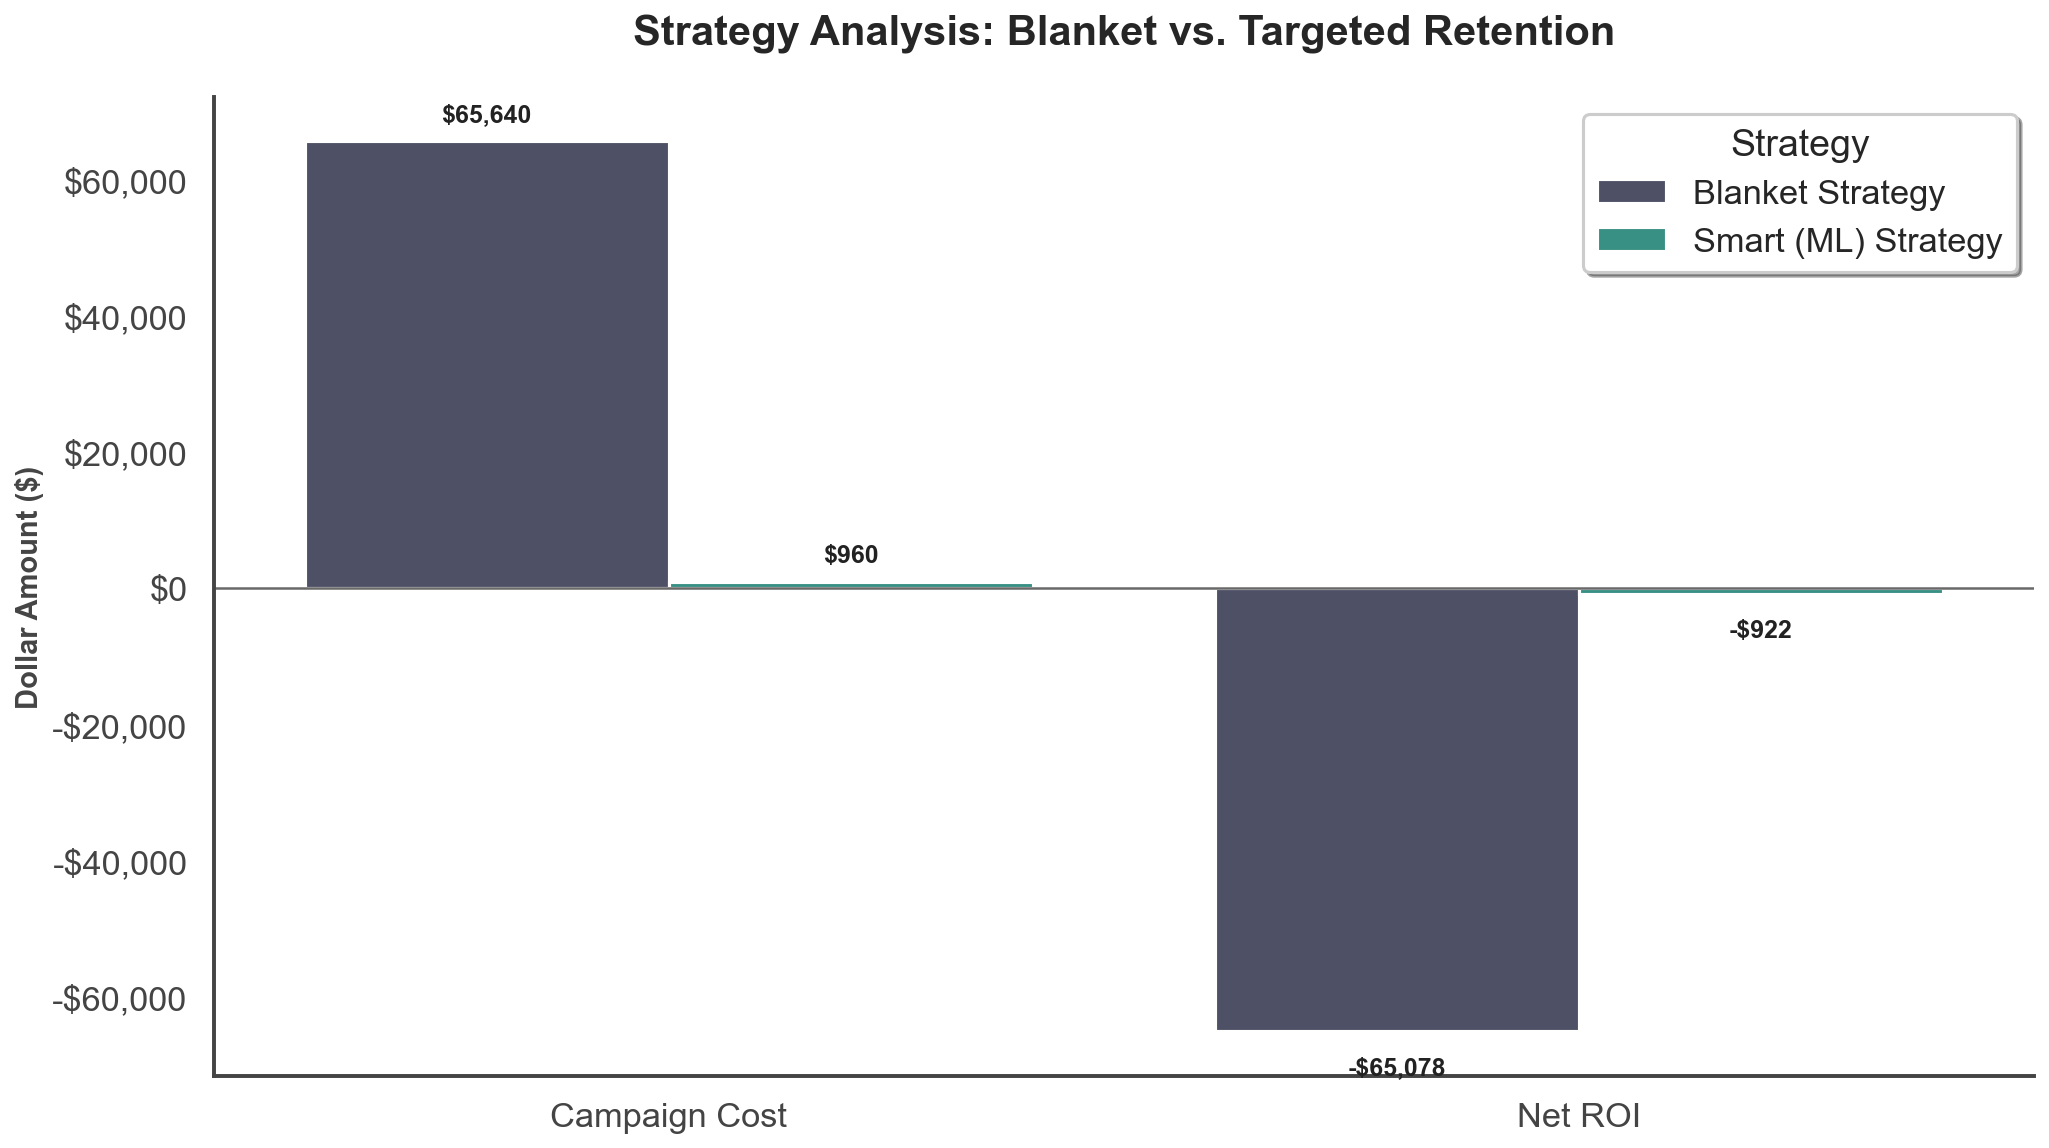

Saved ROI comparison chart to: C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\figures\roi_comparison.png


In [ ]:
from matplotlib.ticker import FuncFormatter

# --- Visual Polish for ROI Comparison ---
plot_data = pd.DataFrame(
    {
        "Strategy": [
            "Blanket Strategy",
            "Smart (ML) Strategy",
            "Blanket Strategy",
            "Smart (ML) Strategy",
        ],
        "Metric": ["Campaign Cost", "Campaign Cost", "Net ROI", "Net ROI"],
        "Value": [blanket_cost, smart_cost, blanket_roi, smart_roi],
    }
)

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=plot_data, x="Metric", y="Value", hue="Strategy", palette=PALETTE)

def dollars_fmt(x: float, _pos: int) -> str:
    sign = "-" if x < 0 else ""
    return f"{sign}${abs(x):,.0f}"

# Clean axis formatting
ax.yaxis.set_major_formatter(FuncFormatter(dollars_fmt))
ax.set_title("Strategy Analysis: Blanket vs. Targeted Retention", fontsize=20, weight="bold", pad=25)
ax.set_ylabel("Dollar Amount ($)", weight="bold")
ax.set_xlabel("")
plt.axhline(0, color="#444444", linewidth=1.2, alpha=0.8)
ax.legend(title="Strategy", loc="best", frameon=True, shadow=True)
SNS_SPINES = ["top", "right"]
for spine in SNS_SPINES:
    ax.spines[spine].set_visible(False)

# Add value labels for better readability on each bar
for patch in ax.patches:
    height = float(patch.get_height())
    if not np.isfinite(height) or abs(height) < 1e-9:
        continue
    label = dollars_fmt(height, 0)
    ax.annotate(
        label,
        xy=(patch.get_x() + patch.get_width() / 2.0, height),
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=12,
        xytext=(0, 7 if height > 0 else -12),
        textcoords="offset points",
        weight="bold",
        color="#222"
    )
plt.tight_layout()

# Save as shareable PNG artifact
out_path = FIG_DIR / "roi_comparison.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved ROI comparison chart to: {out_path}")

### Conclusion

By only targeting people who are actually going to churn AND who are worth saving, this ML strategy drastically cuts campaign costs and increases net ROI vs the standard blanket-discount approach. This is the power of combining predictive modeling with customer segmentation.